### Lousy Dates 

The purpose of this notebook is to identify Miovision's lousy dates. These are dates that have no data, or bad quality data (due to a camera being off-axis, for example).

In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
#this is to allow you to see the plot in the notebook
%matplotlib inline 
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as pyplot
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read(r'/home/scannon/db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [3]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid AS int_uid, intersection_name 
    FROM miovision_api.intersections
    ''')
    int_list = pandasql.read_sql(sql, con)

In [4]:
int_list = int_list.set_index('int_uid')
int_list

intersection_name
int_uid                                           
1                              Adelaide / Bathurst
2                               Adelaide / Spadina
3                                   Adelaide / Bay
4                                Adelaide / Jarvis
5                                 Front / Bathurst
...                                            ...
63            Sheppard Avenue West and Weston Road
64       Yonge Street / Davenport Road / Church St
65                 Bayview Avenue and River Street
66            Sheppard Avenue West and Jane Street
68             Steeles Avenue West and Jane Street

[68 rows x 1 columns]

In [5]:
with con:   
    sql = pg.SQL('''
    select v.intersection_uid, i.intersection_name, date_trunc('month', v.datetime_bin)::date AS mon, sum(v.volume) as car_ct
    from miovision_api.volumes_15min AS v
    left join miovision_api.intersections AS i using (intersection_uid)
    where classification_uid = 1 -- just "lights" aka passenger vehicles
    group by v.intersection_uid, i.intersection_name, date_trunc('month', v.datetime_bin)::date
    ''')
    mio_mon_vol = pandasql.read_sql(sql, con)

In [6]:
mio_mon_vol = mio_mon_vol.set_index(['intersection_uid', 'mon'])

In [14]:
mio_mon_vol = mio_mon_vol.reindex(
    pd.MultiIndex.from_product(mio_mon_vol.index.levels)
)

In [15]:
mio_mon_vol

intersection_name     car_ct
intersection_uid mon                                                        
1                2018-12-01                   Adelaide / Bathurst        0.0
                 2019-01-01                   Adelaide / Bathurst  1217148.0
                 2019-02-01                   Adelaide / Bathurst  1129662.0
                 2019-03-01                   Adelaide / Bathurst  1866416.0
                 2019-04-01                   Adelaide / Bathurst  1730682.0
...                                                           ...        ...
66               2022-11-01  Sheppard Avenue West and Jane Street  2416910.0
                 2022-12-01  Sheppard Avenue West and Jane Street  2351050.0
                 2023-01-01  Sheppard Avenue West and Jane Street  2317420.0
                 2023-02-01  Sheppard Avenue West and Jane Street  2219492.0
                 2023-03-01  Sheppard Avenue West and Jane Street  1825224.0

[3432 rows x 2 columns]

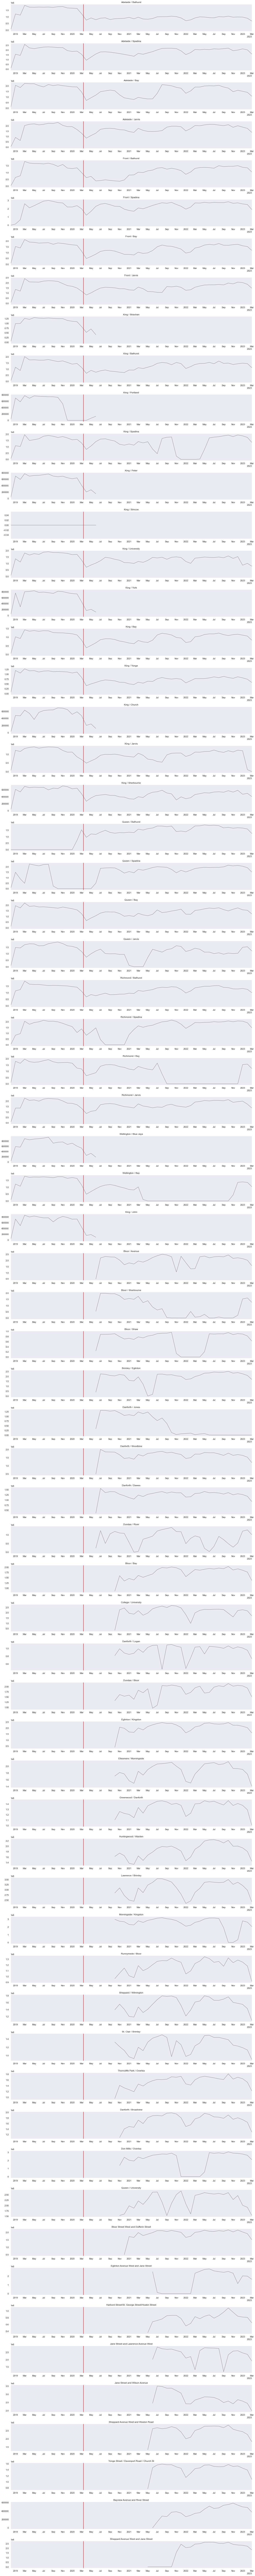

In [9]:
# making charts
locator = mdates.AutoDateLocator(minticks=10, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)

intid = mio_mon_vol.index.unique(level = 'intersection_uid').values

xDateRange = [
    np.min(mio_mon_vol.index.get_level_values('mon')),
    np.max(mio_mon_vol.index.get_level_values('mon'))
]

fig, charts = pyplot.subplots(len(intid),1,figsize=(18,180))
for chart, intid in zip(charts,intid):
    # subset the data to each intersection
    data = mio_mon_vol.xs(intid)
    # plot
    chart.plot(data.index.values, data['car_ct'], color='dimgrey', linewidth=1 )
    chart.xaxis.set_major_locator(locator)
    chart.xaxis.set_major_formatter(formatter)    
    chart.set_xlim( xDateRange )
    chart.set_title(int_list.xs(intid)['intersection_name'], loc='center' )
    chart.axvline( np.datetime64('2020-03-17'), color='red' )
    chart.grid(color='lightgrey')
    
fig.tight_layout()
pyplot.show()

In [24]:
with con:
    sql = pg.SQL('''
    select v.intersection_uid, i.intersection_name, date_trunc('week', v.datetime_bin)::date AS mon, sum(v.volume) as car_ct
    from miovision_api.volumes_15min AS v
    left join miovision_api.intersections AS i using (intersection_uid)
    where classification_uid = 1
    group by v.intersection_uid, i.intersection_name, date_trunc('week', v.datetime_bin)::date
    ''')
    mio_week_vol = pd.read_sql(sql, con)

In [25]:
mio_week_vol = mio_week_vol.set_index(['intersection_uid', 'mon'])

In [26]:
mio_week_vol = mio_week_vol.reindex(
    pd.MultiIndex.from_product(mio_week_vol.index.levels)
)

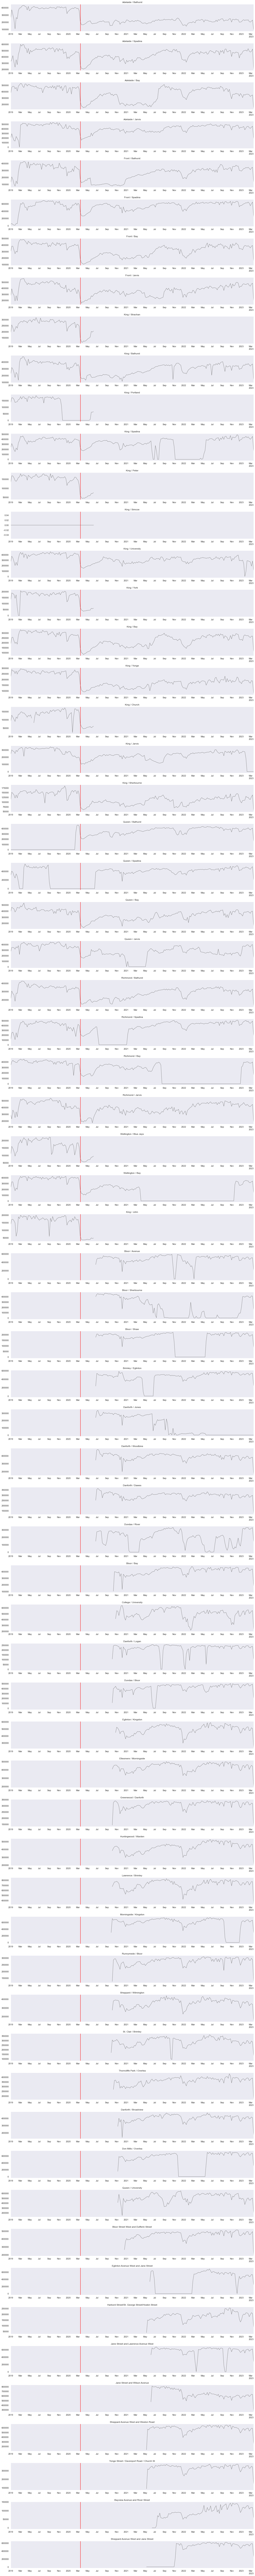

In [27]:
# making charts
locator = mdates.AutoDateLocator(minticks=10, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)

int_id = mio_week_vol.index.unique(level = 'intersection_uid').values

xDateRange = [
    np.min(mio_week_vol.index.get_level_values('mon')),
    np.max(mio_week_vol.index.get_level_values('mon'))
]

fig, charts = pyplot.subplots(len(int_id),1,figsize=(18,180))
for chart, int_id in zip(charts,int_id):
    # subset the data to each intersection
    data = mio_week_vol.xs(int_id)
    # plot
    chart.plot(data.index.values, data['car_ct'], color='dimgrey', linewidth=1 )
    chart.xaxis.set_major_locator(locator)
    chart.xaxis.set_major_formatter(formatter)    
    chart.set_xlim( xDateRange )
    chart.set_title(int_list.xs(int_id)['intersection_name'], loc='center' )
    chart.axvline( np.datetime64('2020-03-17'), color='red' )
    chart.grid(color='lightgrey')
    
fig.tight_layout()
pyplot.show()

In [11]:
with con:   
    sql = pg.SQL('''
    WITH null_15 AS (
    SELECT v.intersection_uid, i.intersection_name, v.datetime_bin, sum(v.volume) as car_ct
    from miovision_api.volumes_15min AS v
    left join miovision_api.intersections AS i using (intersection_uid)
    where classification_uid = 1
    GROUP BY v.intersection_uid, i.intersection_name, v.datetime_bin 
    HAVING sum(v.volume) is null
    )

    select n.intersection_uid, n.intersection_name, n.datetime_bin::date as dt, count(n.datetime_bin) as null_bin
    from null_15 AS n
    group by n.intersection_uid, n.intersection_name, n.datetime_bin::date
    ''')
    null_bins = pandasql.read_sql(sql, con)

In [12]:
null_bins = null_bins.set_index(['intersection_uid', 'dt'])

In [13]:
null_bins

intersection_name  null_bin
intersection_uid dt                                          
27               2020-05-06      Richmond / Spadina         8
15               2022-08-12       King / University         4
8                2021-07-30          Front / Jarvis         4
34               2021-10-23      Bloor / Sherbourne        12
31               2023-02-24        Wellington / Bay         4
...                                             ...       ...
12               2019-09-01          King / Spadina         4
30               2019-05-07  Wellington / Blue Jays         4
13               2019-11-24            King / Peter         4
39               2021-03-24        Danforth / Dawes         5
11               2019-11-01         King / Portland         4

[5840 rows x 2 columns]

In [17]:
null_bins = null_bins.reindex(
    pd.MultiIndex.from_product(mio_mon_vol.index.levels)
)

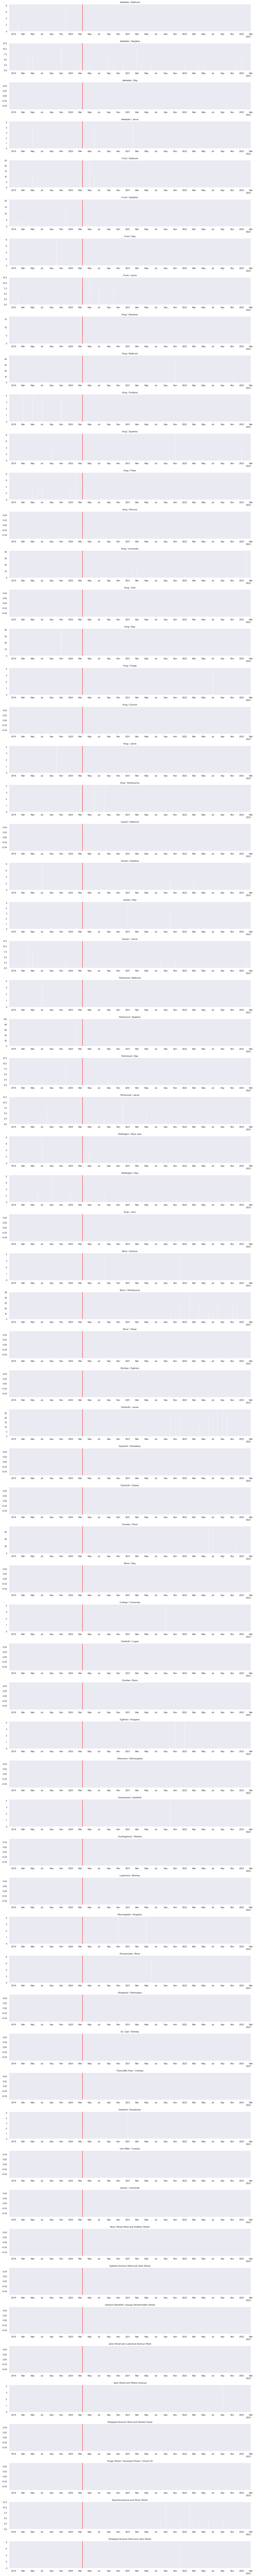

In [28]:
# making charts
locator = mdates.AutoDateLocator(minticks=10, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)

intuid = null_bins.index.unique(level = 'intersection_uid').values

xDateRange = [
    np.min(null_bins.index.get_level_values('mon')),
    np.max(null_bins.index.get_level_values('mon'))
]

fig, charts = pyplot.subplots(len(intuid),1,figsize=(18,180))
for chart, intuid in zip(charts,intuid):
    # subset the data to each intersection
    data = null_bins.xs(intuid)
    # plot
    chart.bar(data.index.values, data['null_bin'], color = 'green', width = 1)
    chart.xaxis.set_major_locator(locator)
    chart.xaxis.set_major_formatter(formatter)    
    chart.set_xlim( xDateRange )
    chart.set_title(int_list.xs(intuid)['intersection_name'], loc='center' )
    chart.axvline( np.datetime64('2020-03-17'), color='red' )
    chart.grid(color='green')
    
fig.tight_layout()
pyplot.show()